In [1]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import  TextConverter
import urllib2
from urllib2 import Request
import datetime
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def parsePDF(url):
    # Open the url provided as an argument to the function and read the content
    open = urllib2.urlopen(Request(url)).read()
    from StringIO import StringIO
    memory_file = StringIO(open)

    # Create a PDF parser object related with the StringIO object
    parser = PDFParser(memory_file)

    #  Stores the document structure in a PDF document object
    document = PDFDocument(parser)
    # Define parameters to the PDF device objet 
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    codec = 'utf-8'

    # Create a PDF device object
    device = TextConverter(rsrcmgr, retstr, codec = codec, laparams = laparams)

    # Create a PDF interpreter object
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Process each page contained in the document
    for page in PDFPage.create_pages(document):
        interpreter.process_page(page)
        data =  retstr.getvalue()
    # print data
    # Get values for 'Iowa B100' prices (free to choose any element from the PDF) 
    reg = '\d.\d{2} - \d.\d{2}'
    matches = re.findall(reg, data) # Our data are contained in matches[0]

    # Compute the average
    # Extract value from previous regex 
    low = re.search('\d.\d{2} -', matches[0])
    high = re.search('- \d.\d{2}', matches[0])
    # Cast string variables to float type
    low_val = float(low.group(0).replace(' -',''))
    high_val = float (high.group(0).replace('- ',''))

    # Calculate the average
    #import numpy
    #value = [high_val, low_val]
    #print value.mean
    ave = (high_val + low_val) /2
    # Search the date of the report 
    reg = '\w{3},\s\w{3}\s\d{2},\s\d{4}'
    match = re.search(reg, data)# Result is contained in matches[0]
    dat = match.group(0)
    
    # Cast to date format
    return(dat, ave)

In [3]:

# The date of the latest weekly price bulletin
start_date = raw_input("Enter last weekly price bulletin date (dd/mm/yyyy): ")

# Convert start_date string to Python date format
dat = datetime.datetime.strptime(start_date,  '%d/%m/%Y')

# Time series length
back_weeks = raw_input("How many weeks back in time: ")


Enter last weekly price bulletin date (dd/mm/yyyy): 06/07/2018
How many weeks back in time: 5


In [4]:
print 'Date as read in PDF' + '\t' + 'Formatted date' + '\t' + 'Value'
res = 'Empty response'

date_list = []
value_list = []
# Loop through the dates
for weeks in xrange(0, int(back_weeks)):

    # Basic exception handling mechamism
    try:           
        wk = datetime.timedelta(weeks = weeks)
        date_back = dat - wk

        # Construct the url
        # example url : https://www.ams.usda.gov/mnreports/lswagenergy.pdf
        url = 'http://search.ams.usda.gov/mndms/' + str(date_back.year) + \
              '/' + str(date_back.month).zfill(2) + '/LS' + str(date_back.year) + \
              str(date_back.month).zfill(2) + str(date_back.day).zfill(2) + \
              'WAGENERGY.PDF'
        
        # Call to function
        fun =  parsePDF(url)
        value_list.append(str(fun[1]))
        date_list.append(fun[0])
        
        # Relevant information extraction
        res = str(fun[0]) + '\t' +  str(date_back.day).zfill(2) + '/' + \
              str(date_back.month).zfill(2) +  '/' + str(date_back.year) + \
              '\t' + str(fun[1])

    except Exception:
        print 'NA\t\t\t' +  str(date_back.day).zfill(2) + '/' + \
              str(date_back.month).zfill(2) +  '/' + str(date_back.year) + \
              '\t' + 'NA'

    # Output onto the screen
    print res


Date as read in PDF	Formatted date	Value
Fri, Jul 06, 2018	06/07/2018	1.42
Fri, Jun 29, 2018	29/06/2018	1.415
Fri, Jun 22, 2018	22/06/2018	1.39
Fri, Jun 15, 2018	15/06/2018	1.39
Fri, Jun 08, 2018	08/06/2018	1.41


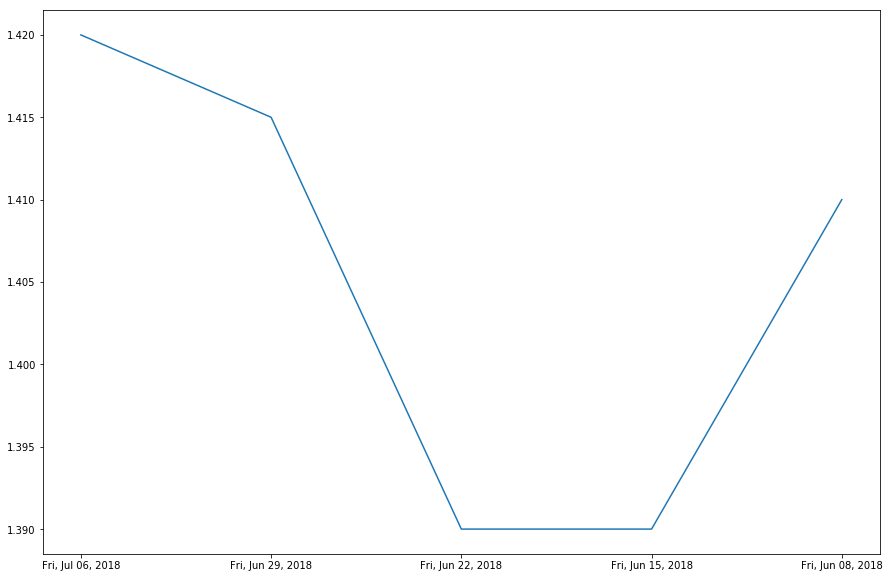

In [5]:
plt.rcParams["figure.figsize"] =(15,10)
plt.xticks(range(int(back_weeks)), date_list)
plt.plot(range(int(back_weeks)), value_list)
plt.show()

In [6]:
# Use above values on your own, to do the further predictions using regression or time-series analysis forecasting